# 10 Different Spoken Digits CNN

Importing packages

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import optimizers

Using TensorFlow backend.


Get import files

In [2]:
print(os.listdir(r"spoken-digit-dataset"))

['dataset', 'dataset.rar', 'free-spoken-digit-dataset-master']


In [3]:
def wav2mfcc(file_path, augment = False, max_pad_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=8000, duration = 1.024)
    
    if augment == True:
        bins_per_octave = 12
        pitch_pm = 4
        pitch_change =  pitch_pm * 2*(np.random.uniform())   
        wave = librosa.effects.pitch_shift(wave, 
                                          8000, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
        
        speed_change = np.random.uniform(low=0.9,high=1.1)
        wave = librosa.effects.time_stretch(wave, speed_change)
        wave = wave[:8192]

    duration = wave.shape[0]/sr
    speed_change = 2.0* duration/1.024
    wave = librosa.effects.time_stretch(wave, speed_change)
    wave = wave[:4096]
    
    wave = librosa.util.normalize(wave)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=40, hop_length=int(0.048*sr), n_fft=int(0.096*sr))
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    #print("shape=",mfcc.shape[1], wave.shape[0])
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #mfcc = mfcc[2:24,:]
    return mfcc, duration, sr

def get_data(dir = '', augment= False):
    labels = []
    mfccs = []
    durations = []
    sampling_rates = []
    filenames = []

    for f in tqdm(os.listdir(dir)):
        if f.endswith('.wav'):
            mfcc, duration, sr = wav2mfcc(dir + "/" + f, augment)
            mfccs.append(mfcc)
            durations.append(duration)
            sampling_rates.append(sr)
            # List of labels
            # original naming convention number_name_version -- 0_jackson_0
            #label = f.split('_')[0]
            # new naming convention name_version_number -- loxwangc_0_0
            label = f.split('_')[2][0]
            labels.append(label)
            filenames.append(dir + "/" + f)
    return filenames, np.asarray(mfccs), np.asarray(durations), np.asarray(sampling_rates), to_categorical(labels), labels

In [4]:
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('spoken-digit-dataset/free-spoken-digit-dataset-master/recordings_mien')

100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [01:11<00:00, 13.39it/s]


In [5]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    max = np.max(images)
    min = np.min(images)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        #ax.imshow(images[i].reshape(img_shape), cmap='binary')
        im = librosa.display.specshow(images[i], ax=ax, vmin=min, vmax=max)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

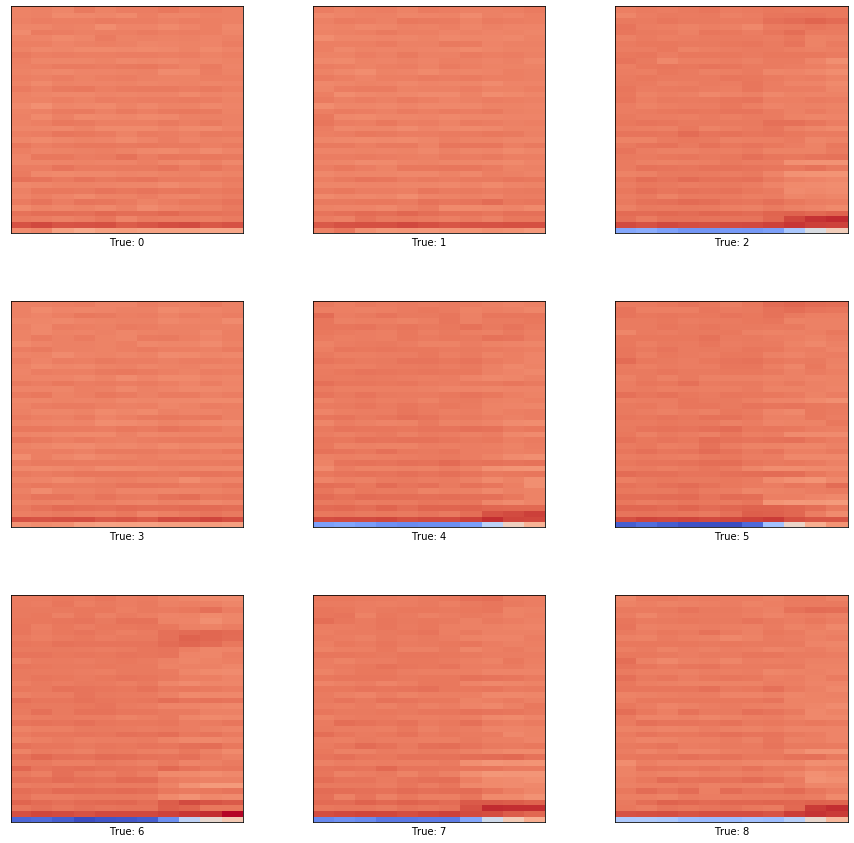

In [6]:
plot_images(mfccs[50:59], cls_true[50:59])

In [7]:
#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

    return model

In [8]:
def get_all():
    filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('spoken-digit-dataset/free-spoken-digit-dataset-master/recordings_mien', augment = False)
    
    filenames_a, mfccs_a, durations_a, sampling_rates_a, labels_a, cls_true_a = get_data('spoken-digit-dataset/free-spoken-digit-dataset-master/recordings_mien', augment = True)

    mfccs = np.append(mfccs, mfccs_a, axis=0)
    labels = np.append(labels, labels_a, axis =0)
    
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10
    
    print("sampling rate (max) = ", np.max(sampling_rates))
    print("sampling rate (min) = ", np.min(sampling_rates))
    print("duration (max) = ", np.max(durations))
    print("duration (avg) = ", np.average(durations))
    print("duration (min) = ", np.min(durations))
    print("mffc matrix = ", mfccs.shape)

    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels

    input_shape = (dim_1, dim_2, channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    model = get_cnn_model(input_shape, classes)

    return X_train, X_test, y_train, y_test, model

In [9]:
X_train, X_test, y_train, y_test, cnn_model = get_all()

print(cnn_model.summary())

cnn_model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.1)

100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [01:35<00:00, 10.07it/s]


sampling rate (max) =  8000
sampling rate (min) =  8000
duration (max) =  1.024
duration (avg) =  0.8887677083333336
duration (min) =  0.18825
mffc matrix =  (1920, 40, 11)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 8, 32)         544       
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 8, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 6, 48)         13872     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 6, 48)         192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 4, 120)        51960     
_________________________________________________________________
batch_normaliza

In [10]:
cnn_model.save("spoken-digit-dataset/free-spoken-digit-dataset-master/models/10spokenDigits_e50_sam960_acc9877_mien.h5")

from tensorflow.keras.models import load_model

# Recreate the exact same model, including its weights and the optimizer
#cnn_model = load_model('spoken-digit-dataset/free-spoken-digit-dataset-master/models/10spokenDigits_e50_acc1.000_sam310_mien.h5')

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 8, 32)         544       
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 8, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 6, 48)         13872     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 6, 48)         192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 4, 120)        51960     
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 4, 120)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 2, 120)        0

In [11]:
pred = cnn_model.predict_classes(X_test)
print(pred.shape)
print(y_test.shape)

(384,)
(384, 10)


In [12]:
perRight=0
perWrong=0
testSamples = int((len(pred))/2)

for i in range(testSamples):
    #print(pred[i])
    result = np.where(y_test[i] == 1)
    #print(result[0])

    if pred[i] == result[0][0]:
        match = "Equal"
        perRight=perRight+1
    else:
        match = "Wrong"
        perWrong=perWrong+1
    
    #print("Actual: {}, Predicted: {}".format(result[0][0],pred[i]))
    
print(testSamples)
percentage = perRight/testSamples*100
print("Percent correct :{}%".format(percentage))

192
Percent correct :63.541666666666664%


In [13]:
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('spoken-digit-dataset/free-spoken-digit-dataset-master/test_recordings_mien')
filenames_a, mfccs_a, durations_a, sampling_rates_a, labels_a, cls_true_a = get_data('spoken-digit-dataset/free-spoken-digit-dataset-master/test_recordings_mien', augment = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.60it/s]


In [14]:
mfccs = np.append(mfccs, mfccs_a, axis=0)
labels = np.append(labels, labels_a, axis =0)

dim_1 = mfccs.shape[1]
dim_2 = mfccs.shape[2]
channels = 1
classes = 10

print("sampling rate (max) = ", np.max(sampling_rates))
print("sampling rate (min) = ", np.min(sampling_rates))
print("duration (max) = ", np.max(durations))
print("duration (avg) = ", np.average(durations))
print("duration (min) = ", np.min(durations))
print("mffc matrix = ", mfccs.shape)

X = mfccs
X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
y = labels

sampling rate (max) =  8000
sampling rate (min) =  8000
duration (max) =  0.7625
duration (avg) =  0.5928875
duration (min) =  0.295875
mffc matrix =  (20, 40, 11)


In [15]:
pred2 = cnn_model.predict_classes(X)
print(pred2.shape)
print(y.shape)

print(pred2)
print(y)

(20,)
(20, 10)
[0 7 2 3 4 5 6 7 8 9 1 1 6 3 4 5 6 9 8 3]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [16]:
perRight=0
perWrong=0
testSamples = int((len(pred2))/2)

for i in range(testSamples):
    result = np.where(y[i] == 1)
    
    if pred2[i] == result[0][0]:
        match = "Equal"
        perRight=perRight+1
    else:
        match = "Wrong"
        perWrong=perWrong+1
    
    
    print("Actual: {}, Predicted: {}".format(result[0][0],pred2[i]))

print(testSamples)
percentage = perRight/(testSamples)*100
print("Percent correct :{}%".format(percentage))

Actual: 0, Predicted: 0
Actual: 1, Predicted: 7
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 4, Predicted: 4
Actual: 5, Predicted: 5
Actual: 6, Predicted: 6
Actual: 7, Predicted: 7
Actual: 8, Predicted: 8
Actual: 9, Predicted: 9
10
Percent correct :90.0%


In [59]:
from playsound import playsound

playsound(filenames[6])

In [50]:
import sounddevice
from scipy.io.wavfile import write

fs=44100
second=2
print("recording...")
record_voice=sounddevice.rec(int(second * fs),samplerate=fs,channels=2)
sounddevice.wait()
write("spoken-digit-dataset/free-spoken-digit-dataset-master/test_recordings_mien/output_14_0.wav",fs,record_voice)
print("recording written to file")


recording...
recording written to file


In [23]:
os.remove("spoken-digit-dataset/free-spoken-digit-dataset-master/test_recordings_mien/output_14_1.wav")